In [1]:
# adapted (copy pasted) from https://github.com/znxlwm/pytorch-MNIST-CelebA-GAN-DCGAN
import os, time
import matplotlib.pyplot as plt
# import itertools
import pickle
# import imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
# from torch.autograd import Variable

In [1]:
class discriminator(nn.Module):
    def __init__(self, d=64):
        super(discriminator, self).__init__()
        # change all the 4,2,1) to 5,2) because that's how pacgan does it???
        self.conv1 = nn.Conv2d(3, d, 4, 2, 1) # in_channel, out_channel, kernel size, stride, padding
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.conv4 = nn.Conv2d(d*4, d*8, 4, 2, 1)
        self.conv4_bn = nn.BatchNorm2d(d*8)
        self.conv5 = nn.Conv2d(d*8, 1, 4, 1, 0)
    
    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):
        x = F.leaky_relu(self.conv1(input), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = F.sigmoid(self.conv5(x))
        return x

NameError: name 'nn' is not defined

In [2]:
# G(z)
class generator(nn.Module):
    # initializers
    def __init__(self, d=128):
        super(generator, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(100, d*8, 4, 1, 0)
        self.deconv1_bn = nn.BatchNorm2d(d*8)
        self.deconv2 = nn.ConvTranspose2d(d*8, d*4, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d*4)
        self.deconv3 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d*2)
        self.deconv4 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(d)
        self.deconv5 = nn.ConvTranspose2d(d, 1, 4, 2, 1)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):
        # x = F.relu(self.deconv1(input))
        x = F.relu(self.deconv1_bn(self.deconv1(input)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = F.relu(self.deconv4_bn(self.deconv4(x)))
        x = F.tanh(self.deconv5(x))
        return x

In [3]:
class discriminator(nn.Module):
    # initializers
    def __init__(self, d=128):
        super(discriminator, self).__init__()
        self.conv1 = nn.Conv2d(1, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.conv4 = nn.Conv2d(d*4, d*8, 4, 2, 1)
        self.conv4_bn = nn.BatchNorm2d(d*8)
        self.conv5 = nn.Conv2d(d*8, 1, 4, 1, 0)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):
        x = F.leaky_relu(self.conv1(input), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = F.sigmoid(self.conv5(x))
        return x

In [4]:
def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

In [7]:
fixed_z_ = torch.randn((5 * 5, 100)).view(-1, 100, 1, 1)    # fixed noise
# fixed_z_ = Variable(fixed_z_.cuda(), volatile=True)

In [8]:
# training parameters
batch_size = 128
lr = 0.0002
train_epoch = 20

# data_loader
# img_size = 64
# transform = transforms.Compose([
#         transforms.Scale(img_size),
#         transforms.ToTensor(),
#         transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
# ])
# train_loader = torch.utils.data.DataLoader(
#     datasets.MNIST('data', train=True, download=True, transform=transform),
#     batch_size=batch_size, shuffle=True)

Processing...
Done!


In [ ]:
f.read(16)
buffer = f.read(hw * n)
images = np.frombuffer(buffer, dtype=np.uint8)
images = images.reshape(n, hw)

In [9]:
# network
G = generator(128)
D = discriminator(128)
G.weight_init(mean=0.0, std=0.02)
D.weight_init(mean=0.0, std=0.02)
# G.cuda()
# D.cuda()

In [10]:
# Binary Cross Entropy loss
BCE_loss = nn.BCELoss()

# Adam optimizer
G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

In [11]:
# results save folder
if not os.path.isdir('MNIST_DCGAN_results'):
    os.mkdir('MNIST_DCGAN_results')
if not os.path.isdir('MNIST_DCGAN_results/Random_results'):
    os.mkdir('MNIST_DCGAN_results/Random_results')
if not os.path.isdir('MNIST_DCGAN_results/Fixed_results'):
    os.mkdir('MNIST_DCGAN_results/Fixed_results')

train_hist = {}
train_hist['D_losses'] = []
train_hist['G_losses'] = []
train_hist['per_epoch_ptimes'] = []
train_hist['total_ptime'] = []
num_iter = 0

In [13]:
x = next(iter(train_loader))

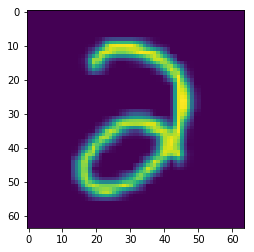

In [19]:
x[0].shape
%matplotlib inline
plt.imshow(x[0][0,0])


In [26]:
print(fixed_z_.shape)
print(G.deconv1(fixed_z_).shape)
print(G.deconv2(G.deconv1(fixed_z_)).shape)

torch.Size([25, 100, 1, 1])
torch.Size([25, 1024, 4, 4])
torch.Size([25, 512, 8, 8])


In [22]:
G(fixed_z_).shape

C:\Users\owner\Anaconda3\lib\site-packages\torch\nn\functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


torch.Size([25, 1, 64, 64])

In [23]:
G

generator(
  (deconv1): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1))
  (deconv1_bn): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv2): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv2_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv3_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv4): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv4_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv5): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)

In [40]:
D

discriminator(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv3_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv4_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
)

In [46]:
image = torch.zeros(50,3,28,28)
D = discriminator(64)
D.conv1(image).shape, D.conv2(D.conv1(image)).shape, D.conv3(D.conv2(D.conv1(image))).shape
D.conv4(D.conv3(D.conv2(D.conv1(image)))).shape

torch.Size([50, 512, 1, 1])

In [27]:

import math
import numpy as np 
import tensorflow as tf

from tensorflow.python.framework import ops


In [30]:
def conv2d(input_, output_dim, 
       k_h=5, k_w=5, d_h=2, d_w=2, stddev=0.02,
       name="conv2d"):
  with tf.variable_scope(name):
    w = tf.get_variable('w', [k_h, k_w, input_.get_shape()[-1], output_dim],
              initializer=tf.truncated_normal_initializer(stddev=stddev))
    conv = tf.nn.conv2d(input_, w, strides=[1, d_h, d_w, 1], padding='SAME')

    biases = tf.get_variable('biases', [output_dim], initializer=tf.constant_initializer(0.0))
    conv = tf.reshape(tf.nn.bias_add(conv, biases), conv.get_shape())

    return conv

In [31]:
image = np.zeros((50,28,28,3))
conv2d(image,64)

TypeError: Input 'filter' of 'Conv2D' Op has type float32 that does not match type float64 of argument 'input'.